<a href="https://colab.research.google.com/github/DrAlexSanz/RL-examples/blob/main/Cart_pole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/6-Other/22-DeepRL/CartPole-RL-PyTorch.ipynb

In [34]:
!pip install gym

In [35]:
# See what I have
import gym

env = gym.make("CartPole-v1", render_mode='human')

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(




Now let's create the CartPole environment and see how to operate on it. An environment has the following properties:

* Action space is the set of possible actions that we can perform at each step of the simulation.
* Observation space is the space of observations that we can make.



Let's see how the simulation works. The following loop runs the simulation, until env.step does not return the termination flag done. We will randomly chose actions using env.action_space.sample(), which means the experiment will probably fail very fast (CartPole environment terminates when the speed of CartPole, its position or angle are outside certain limits).

    Simulation will open in the new window. You can run the code several times and see how it behaves.



In [36]:
env.reset()

done = False
total_reward = 0
while not done:
   #env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   total_reward += rew
   print(f"{obs} -> {rew}")
print(f"Total reward: {total_reward}")

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[-0.04872866  0.16605794  0.01814307 -0.25094622] -> 1.0
[-0.0454075   0.36091617  0.01312414 -0.5378517 ] -> 1.0
[-0.03818917  0.55585116  0.00236711 -0.8263706 ] -> 1.0
[-0.02707215  0.7509407  -0.0141603  -1.1183081 ] -> 1.0
[-0.01205334  0.5560074  -0.03652646 -0.8301005 ] -> 1.0
[-9.3318929e-04  7.5160909e-01 -5.3128473e-02 -1.1340437e+00] -> 1.0
[ 0.01409899  0.5572211  -0.07580934 -0.8584856 ] -> 1.0
[ 0.02524341  0.3632092  -0.09297906 -0.59057015] -> 1.0
[ 0.0325076   0.5595015  -0.10479046 -0.91103333] -> 1.0
[ 0.04369763  0.75587344 -0.12301113 -1.2347274 ] -> 1.0
[ 0.0588151   0.5625284  -0.14770567 -0.9829755 ] -> 1.0
[ 0.07006566  0.7592874  -0.1673652  -1.3181682 ] -> 1.0
[ 0.08525141  0.56662995 -0.19372855 -1.0821959 ] -> 1.0
[ 0.09658401  0.3745184  -0.21537247 -0.8560198 ] -> 1.0
Total reward: 14.0


Youn can notice that observations contain 4 numbers. They are:

* Position of cart.
* Velocity of cart.
* Angle of pole.
* Rotation rate of pole.

rew is the reward we receive at each step. You can see that in CartPole environment you are rewarded 1 point for each simulation step, and the goal is to maximize total reward, i.e. the time CartPole is able to balance without falling.

During reinforcement learning, our goal is to train a policy $\pi$, that for each state $s$ will tell us which action $a$ to take, so essentially $a = \pi(s)$.

If you want probabilistic solution, you can think of policy as returning a set of probabilities for each action, i.e. $\pi(a|s)$
would mean a probability that we should take action $a$ at state $s$.

## Policy Gradient Method

In simplest RL algorithm, called Policy Gradient, we will train a neural network to predict the next action.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch

num_inputs = 4
num_actions = 2

model = torch.nn.Sequential(
                            torch.nn.Linear(in_features = num_inputs, out_features = 128, bias = True, dtype = torch.float32),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features = 128, out_features = 2, bias = True, dtype = torch.float32),
                            torch.nn.Softmax(dim = 1)
                            )



We will train the network by running many experiments, and updating our network after each run. Let's define a function that will run the experiment and return the results (so-called trace) - all states, actions (and their recommended probabilities), and rewards:

In [38]:
def run_episode(max_steps_per_episode = 10000, render = False):

    states, actions, probs, rewards = [], [], [], []
    state = env.reset()

    for _ in range(max_steps_per_episode):
        action_probs = model(torch.from_numpy(np.expand_dims(state, 0)))[0]
        action = np.random.choice(num_actions, p = np.squeeze(action_probs.detach().numpy())) # num actions is defined at the beginning (left or right)
        nstate, reward, done, info = env.step(action)

        if done:
            break

        states.append(state)
        actions.append(action)
        probs.append(action_probs.detach().numpy())
        rewards.append(reward)
        state = nstate

    return np.vstack(states), np.vstack(actions), np.vstack(probs), np.vstack(rewards)




You can run one episode with untrained network and observe that total reward (AKA length of episode) is very low:

In [39]:
s, a, p, r = run_episode()
print(f"Total reward: {np.sum(r)}")

Total reward: 21.0


One of the tricky aspects of policy gradient algorithm is to use **discounted rewards.** The idea is that we compute the vector of total rewards at each step of the game, and during this process we discount the early rewards using some coefficient $\gamma$. We also normalize the resulting vector, because we will use it as weight to affect our training:

In [40]:
eps = 1e-4 # To avoid division by zero later

def discounted_rewards(rewards, gamma = 0.99, normalize = True):

    ret = []
    s = 0

    for r in rewards[::-1]:
        s = r + gamma * s
        ret.insert(0, s)

    if normalize:
        ret = (ret - np.mean(ret))/(np.std(ret) + eps)

    return ret



Now let's do the actual training! We will run 300 episodes, and at each episode we will do the following:

1. Run the experiment and collect the trace
2. Calculate the difference (gradients) between the actions taken, and by predicted probabilities. The less the difference is, the more we are sure that we have taken the right action.
3. Calculate discounted rewards and multiply gradients by discounted rewards - that will make sure that steps with higher rewards will make more effect on the final result than lower-rewarded ones
4. Expected target actions for our neural network would be partly taken from the predicted probabilities during the run, and partly from calculated gradients. We will use alpha parameter to determine to which extent gradients and rewards are taken into account - this is called learning rate of reinforcement algorithm.
5. Finally, we train our network on states and expected actions, and repeat the process



In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train_on_batch(x, y):

    x = torch.from_numpy(x)
    y = torch.from_numpy(y)

    optimizer.zero_grad()
    predictions = model(x)

    loss = -torch.mean(torch.log(predictions) * y)

    loss.backward()
    optimizer.step()

    return loss




In [43]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

model.to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

In [45]:
alpha = 1e-4
num_epochs = 300
history = []

for epoch in range(num_epochs):

    states, actions, probs, rewards = run_episode() # It already has defaults

    one_hot_actions = np.eye(2)[actions.T][0]
    gradients = one_hot_actions - probs

    dr = discounted_rewards(rewards)
    gradients *= dr
    target = alpha * np.vstack([gradients]) + probs

    train_on_batch(states, target)
    history.append(np.sum(rewards))

    if epoch % 25 == 0:
        print(f"Epoch {epoch}, reward: {np.sum(rewards)}")

plt.plot(history)



Epoch 0, reward: 12.0
Epoch 25, reward: 30.0
Epoch 50, reward: 117.0


KeyboardInterrupt: 

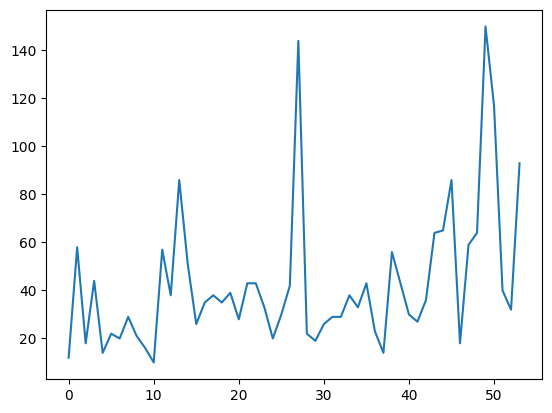

In [46]:
plt.plot(history)